# TensorMap inspection notebook - to make plots for further analysis or publications
__Written by James Ball__  
__Date: 19/12/2025__

In [ ]:
IMAGED11_PATH = None  # means do not use git, otherwise "ImageD11" or "ImageD11_version_xx", etc
CHECKOUT_PATH = None  # None means guess, or you can specify a folder for the checkout

# path to TensorMap h5 file
tmap_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_refined_tmap_Si.h5'

In [ ]:
if IMAGED11_PATH is not None:
    exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())
    setup_ImageD11_from_git(CHECKOUT_PATH, IMAGED11_PATH)

In [ ]:
from pprint import pprint
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

from ImageD11.sinograms.tensor_map import TensorMap, fast_invert, ubi_and_b_to_u, ubi_and_unitcell_to_eps_crystal
from ImageD11.nbGui.nb_utils import plot_all_ipfs_from_meta_orien, plot_inverse_pole_figure_from_meta_orien

%matplotlib inline

# Load data
## TensorMap

In [ ]:
tmap = TensorMap.from_h5(tmap_path)

# Data layout
## What's in the file and how?
You can think of a TensorMap as a Python dictionary of Numpy arrays, each containing different quantities.  
Let's find out what's in the TensorMap we just loaded:

In [ ]:
pprint(list(tmap.keys()))

At its core, a TensorMap that you might generate from a S3DXRD experiment has some fundamental fields/maps/arrays:  
- `tmap.UBI` - a map of the UBI matrices that you measured  
- `tmap.phase_ids`- a map of integer phase ids, so we remember which phase is which  
- `tmap.phases` - a Python dictionary of `ImageD11.unitcell.unitcell` objects, built automatically from the .h5 file.

The integer phase ids from `tmap.phase_ids` are the keys to `tmap.phases`.  
Let's inspect the UBI field:

In [ ]:
tmap.UBI.shape, tmap.UBI.dtype

Every field in a TensorMap must have the same general shape.  
The fields have shape `(NZ, NY, NX, ...)` where the trailing dimensions represent the shape of the underlying thing you can plot.  
In the case of a `UBI` matrix, these have shapes `(3, 3)`, so we end up with `(NZ, NY, NX, 3, 3)` as the final shape of the UBI map.  
Let's take another field as an example:

In [ ]:
tmap.phase_ids.shape

Because `tmap.phase_ids` is a map of scalars, it only has the shape `(NZ, NY, NX)`. This is also true for `tmap.intensity` and `tmap.labels` etc if you have them (from a tomographic index).  
You can also access the fundamental shape of the TensorMap via `tmap.shape`.  
The fields are arranged such that lower values along the axis have lower indices.  
This means that the sample x value increases from `tmap.phase_ids[:, :, 0]` (first value along X) to `tmap.phase_ids[:, :, -1]` (last value along X).  
This is true for all axes. The main justification for this is that you can natively plot it in Paraview, which has limited support for modified array ordering.

In [ ]:
tmap.shape

# Derived quantities

Many of the fields that you may be interested in, such as a field of U matrices, Euler angles, or IPF colours, are derived from each other.  
To put it another way, the fundamental measurement in S3DXRD is a UBI matrix (and a separate strain tensor in the lab frame, if you performed a refinement).  
Every other quantiy that I mentioned are computed *from* the UBI matrices. For an easier-to-understand example, check out the `ImageD11.grain.grain` class which embodies this in practice.

What this means for TensorMaps:
- By default, we keep `UBI`
- We compute other fields, such as `U` or `euler`, if and only if you ask for them (or if we need them for further computation).

Let's examine this in practice. Right now, we don't have a `tmap.euler` field, but we can compute it:

In [ ]:
pprint(list(tmap.keys()))  # no Euler
print(tmap.euler[0, 0, 0])  # print the first element (in the corner, so it'll probably be NaN which is fine)
pprint(list(tmap.keys()))  # now we have Euler!

When we export a TensorMap to disk, we export only what has been computed, to save time.

# Caveat - post-refinement maps
We often use the TensorMap class after performing a point-by-point refinement of the local strains and orientations.  
There is an important caveat that you need to be aware of before continuing.  
We perform the refinement of the `UBI` matrix and the strain tensor (in the lab frame) *separately* during the refinement procedure.  
This means that the strains you can derive from the `UBI` matrix (from the `B` matrix, specifically) don't always agree with the strains we independently refine.  
I recommend that you consider exploring the `incorporate_strains.ipynb` notebook first if you care about fields derived from the `B` matrix (such as `unitcell`).
Orientation fields are unchanged.

# Orientations

We can inspect grain orientations in a few different ways.  
Let's start with the built-in IPF plots.

In [ ]:
# compute ipf maps if we haven't done so already
if 'ipf_x' not in tmap.keys():
    tmap.get_ipf_maps()
tmap.plot('ipf_x')
tmap.plot('ipf_y')
tmap.plot('ipf_z')

This also introduces us to the default plotting function available for simple plots in the TensorMap class.  
Available plots are:
- Any scalar (like labels, or intensity)
- IPF-(X,Y,Z)

In case you have multiple Z layers, you can specify which with the `z_layer=` argument.  
The units of the plot are in voxels, so you need to multiply by the voxel size, which we can get from `tmap.steps` (same units as dty motor):

In [ ]:
tmap.steps

In [ ]:
tmap.plot??

We could also plot inverse pole figures directly, using Orix.

In [ ]:
# first, we need to compute meta orix orientations (should take a few seconds)
tmap.get_meta_orix_orien(phase_id=0)

# now we have an orix orientation object from the IPF plots, so we can use the above function directly to save time
# take every 30th orientation to go faster
plot_all_ipfs_from_meta_orien(tmap._meta_orix_oriens[0][::30], tmap.phases[0])

If you have a `tmap.labels` field, we can take one orientation per label to be even more representative with some clever Numpy slicing:

In [ ]:
# get unique flat indices to labels
unique_labels, unique_indices_flat = np.unique(tmap.labels, return_index=True)
# the indices are flat over (NZ, NY, NX) so we need to correctly access:
unique_U = tmap.U.reshape(-1, 3, 3)[unique_indices_flat]
print(unique_U.shape)
unique_meta_orien = tmap.phases[0].get_orix_orien_fast(unique_U)

plot_inverse_pole_figure_from_meta_orien(tmap._meta_orix_oriens[0][::30], tmap.phases[0])  # the previous plot
ax = plt.gca()
ax.set_title('Z - Downsampled map')

plot_inverse_pole_figure_from_meta_orien(unique_meta_orien, tmap.phases[0])  # just the unique grains
ax = plt.gca()
ax.set_title('Z - One point per unique grain label')

# Strains

Strains in the TensorMap class are special. There are two ways of getting them:
- From the UBI matrix. We go `UBI` -> `eps_sample` or `UBI` -> `eps_crystal` depending on what you asked for
- From the refinement - then it already exists in the refinement output.

Let's plot some! We'll start with strain in the sample frame:

In [ ]:
indices = np.hstack((np.diag_indices(3), np.triu_indices(3, k=1))).T  # plot diagonals, then shear terms

cmap = plt.get_cmap('RdBu_r')  # colour map
normalizer = Normalize(-5e-3, 5e-3)  # colour range
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)  # to make a colorbar

fig, axs = plt.subplots(2,3, sharex=True, sharey=True, layout='constrained', figsize=(10,7))

for row, ij in enumerate(indices):
    i, j = ij
    plotcol = row % 3
    plotrow = np.floor(row/3).astype(int)
    axs[plotrow,plotcol].imshow(tmap.eps_sample[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')
    axs[plotrow,plotcol].set_title(f'eps_{'xyz'[i]}{'xyz'[j]}')

fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('eps_sample')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

We have a few other strain fields we can plot. Let's try `eps_crystal`, which is a tensor rotation of `eps_sample` via `U`:

In [ ]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, layout='constrained', figsize=(10,7))

for row, ij in enumerate(indices):
    i, j = ij
    plotcol = row % 3
    plotrow = np.floor(row/3).astype(int)
    axs[plotrow,plotcol].imshow(tmap.eps_crystal[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')
    axs[plotrow,plotcol].set_title(f'eps_{'xyz'[i]}{'xyz'[j]}')

fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('eps_crystal')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

We also have hydrostatic and deviatoric elements. The hydrostatic component is a scalar, but it's provided as a matrix where all the diagonals are the same for easier further computations. We'll just plot a single image for hydrostatic:

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(7,7))
ax.imshow(tmap.eps_hydro[0, ..., 0, 0], origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')
fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('eps_hydro (scalar)')
fig.colorbar(im, ax=ax)
plt.show()

The deviatoric strain is a tensor, so back to the 2x3 plot:

In [ ]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, layout='constrained', figsize=(10,7))

for row, ij in enumerate(indices):
    i, j = ij
    plotcol = row % 3
    plotrow = np.floor(row/3).astype(int)
    axs[plotrow,plotcol].imshow(tmap.eps_devia[0, ..., i, j], origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')
    axs[plotrow,plotcol].set_title(f'eps_{'xyz'[i]}{'xyz'[j]}')

fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('eps_deviatoric')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

The available strain field methods are listed here:

- `tmap.eps_crystal` - strain tensor in the crystal frame
- `tmap.eps_sample` - strain tensor in the lab frame
- `tmap.eps_hydro` - hydrostatic strain field
- `tmap.eps_devia` - deviatoric strains - just `tmap.eps_sample` - `tmap.eps_hydro`

# Stress

We have some (slightly limited) support for stress tensor generation in the TensorMap class.  
Right now, you can only compute stresses one phase at at time.  
You need to supply a 6x6 stiffness matrix.  
In this notebook we find one for pure Titanium and use it.

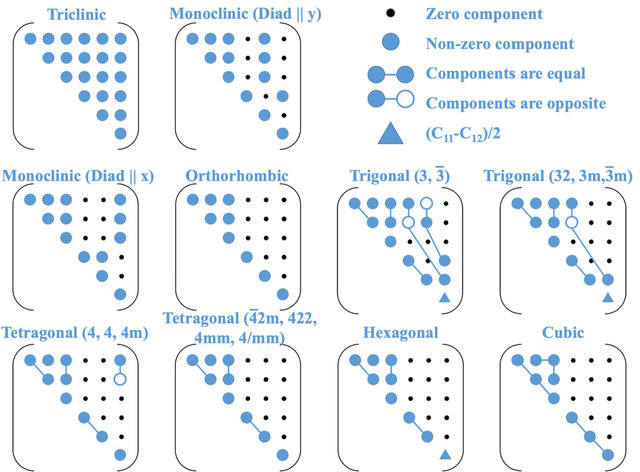

In [ ]:
# 10.1103/PhysRev.135.A482
# Table IV
# converted from 10^12 dynes/cm2 to GPa

c11 = 162.4
c12 = 92.0
c13 = 69.0
c33 = 180.7
c44 = 46.7
c66 = 35.2

D = np.array([
    [c11, c12, c13,   0,   0,   0],
    [c12, c11, c13,   0,   0,   0],
    [c13, c13, c33,   0,   0,   0],
    [  0,   0,   0, c44,   0,   0],
    [  0,   0,   0,   0, c44,   0],
    [  0,   0,   0,   0,   0, c66]
])

print(D)
assert np.allclose(D, D.T)  # make sure D is symmetric

Now that we have a 6x6 stiffness matrix, we can compute the stress fields.

In [ ]:
tmap.get_stress(D, phase_id=0)

In [ ]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, layout='constrained', figsize=(10,7))

cmap = plt.get_cmap('RdBu_r')  # colour map
normalizer = Normalize(-500, 500)  # colour range
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)  # to make a colorbar

for row, ij in enumerate(indices):
    i, j = ij
    plotcol = row % 3
    plotrow = np.floor(row/3).astype(int)
    axs[plotrow,plotcol].imshow(tmap.sig_sample[0, ..., i, j] * 1000, origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')  # we multiply by 1000 here to get MPa
    axs[plotrow,plotcol].set_title(f'sig_{'xyz'[i]}{'xyz'[j]}')

fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('sig_sample (MPa)')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, layout='constrained', figsize=(10,7))

cmap = plt.get_cmap('RdBu_r')  # colour map
normalizer = Normalize(-500, 500)  # colour range
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)  # to make a colorbar

for row, ij in enumerate(indices):
    i, j = ij
    plotcol = row % 3
    plotrow = np.floor(row/3).astype(int)
    axs[plotrow,plotcol].imshow(tmap.sig_crystal[0, ..., i, j] * 1000, origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')    # we multiply by 1000 here to get MPa
    axs[plotrow,plotcol].set_title(f'sig_{'xyz'[i]}{'xyz'[j]}')

fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('sig_crystal (MPa)')
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

Like with strain, we have some derived fields such as hydrostatic and deviatoric, but also the von-Mises:

In [ ]:
cmap = plt.get_cmap('viridis')  # colour map
normalizer = Normalize(0, 800)  # colour range
im = cm.ScalarMappable(norm=normalizer, cmap=cmap)  # to make a colorbar

fig, ax = plt.subplots(layout='constrained', figsize=(7,7))
ax.imshow(tmap.sig_mises[0, ...] * 1000, origin="lower", cmap=cmap, norm=normalizer, interpolation='nearest')    # we multiply by 1000 here to get MPa
fig.supxlabel('Lab X axis --->')
fig.supylabel('Lab Y axis --->')
fig.suptitle('sig_mises (scalar) (MPa)')
fig.colorbar(im, ax=ax)
plt.show()

The available stress field methods are listed here. The units always follow the units of the stiffness tensor you supplied (in our case, GPa):

- `tmap.sig_crystal` - stress tensor in the crystal frame
- `tmap.sig_sample` - stress tensor in the lab frame
- `tmap.sig_hydro` - hydrostatic stress field
- `tmap.sig_devia` - deviatoric stresses - just `tmap.sig_sample` - `tmap.sig_hydro`
- `tmap.sig_mises` - General von-Mises stresses - $\sigma _{\text{v}}={\sqrt {{\frac {1}{2}}\left[(\sigma _{11}-\sigma _{22})^{2}+(\sigma _{22}-\sigma _{33})^{2}+(\sigma _{33}-\sigma _{11})^{2}\right]+3\left(\sigma _{12}^{2}+\sigma _{23}^{2}+\sigma _{31}^{2}\right)}}$

# Unit cell
It can often be useful to directly plot the lattice parameters, especially if you have a non-cubic unit cell where things like $c/a$ ratio are important.
It's also a good opportunity to demonstrate histograms, which are quite easy to plot from Numpy arrays:

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(7,7))
ax.hist(tmap.unitcell[0, ..., 0].ravel(), bins=500)
ax.axvline(tmap.phases[0].lattice_parameters[0], color='red', label='$a_0$')
ax.set(title='Lattice parameter $a$', xlabel='Cell length', ylabel='Count')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(7,7))
ax.hist(tmap.unitcell[0, ..., :2].mean(axis=-1).ravel(), bins=500)
ax.axvline(tmap.phases[0].lattice_parameters[0], color='red', label='$a_0$')
ax.set(title='Lattice parameter $a,b$ mean', xlabel='Cell length', ylabel='Count')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(7,7))
ax.hist((tmap.unitcell[0, ..., 2]/tmap.unitcell[0, ..., :2].mean(axis=-1)).ravel(), bins=500)
ax.axvline(tmap.phases[0].lattice_parameters[2]/tmap.phases[0].lattice_parameters[0], color='red', label='$c_0/a_0$')
ax.set(title='$c/a$ ratio', xlabel='Ratio', ylabel='Count')
ax.legend()
plt.show()

# Conclusion
That's it for now - hopefully this notebook gives you a taste of the sort of processing you can do with a TensorMap.